<a href="https://colab.research.google.com/github/cesartejido/TFG-Herramienta-Medicina-de-Precision/blob/main/Estructura3D_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Introducir secuencia(s) de proteínas
from google.colab import files
import os
import re

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK'



jobname = 'Estructura3D'

# Eliminar espacios en blanco de la secuencia
query_sequence = "".join(query_sequence.split())

# Crear un directorio para guardar los resultados
os.makedirs(jobname, exist_ok=True)

# Guardar las consultas en un archivo CSV
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname Estructura3D
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [2]:
#@title Instalar dependencias
%%time
import os

# Instalar ColabFold, desde github
if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")

  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")


CPU times: user 938 µs, sys: 0 ns, total: 938 µs
Wall time: 944 µs


In [3]:
#@title Opciones de MSA (Alineamiento de Secuencias Multiples)(subida de MSA personalizado, secuencia única, modo de emparejamiento)
msa_mode = "single_sequence"
# "mmseqs2_uniref_env","single_sequence" tener en cuenta las dos por ahora

# Selección archivo A3M
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)


In [4]:
#@title Configuraciones avanzadas
model_type = "auto"
num_recycles = 3

In [5]:
#@title Run Prediction

display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt


result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True


download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    stop_at_score=float(100),
    zip_results=False,
    use_cluster_profile=use_cluster_profile,
    user_agent="colabfold/google-colab-main"
)



2025-01-23 18:36:57,283 Running on GPU
2025-01-23 18:36:57,464 Found 2 citations for tools or databases
2025-01-23 18:36:57,464 Query 1/1: Estructura3D (length 59)
2025-01-23 18:37:22,904 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=56.9 pTM=0.375
2025-01-23 18:37:23,284 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=60.8 pTM=0.41 tol=1.54
2025-01-23 18:37:23,664 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=62.6 pTM=0.415 tol=0.716
2025-01-23 18:37:24,043 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.4 pTM=0.433 tol=0.26
2025-01-23 18:37:24,045 alphafold2_ptm_model_1_seed_000 took 15.5s (3 recycles)
2025-01-23 18:37:24,436 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=52.3 pTM=0.375
2025-01-23 18:37:24,817 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=55.4 pTM=0.404 tol=1.66
2025-01-23 18:37:25,198 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=58.7 pTM=0.402 tol=0.691
2025-01-23 18:37:25,577 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=60.6 pTM=0.399 tol=0.698
2025

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

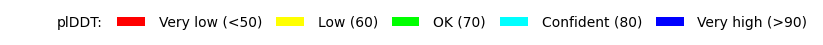

In [9]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend ##Muestra escala de confianza

from colabfold.colabfold import pymol_color_list, alphabet_list

rank_num = 1
color = "lDDT"

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})

  view.zoomTo()
  return view

show_pdb(rank_num, color).show()
if color == "lDDT":
  plot_plddt_legend().show()